In [1]:
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from keras import models

In [2]:
from keras import Model
from keras import Layer

def import_model(filepath: str) -> Model:
    """Load model from file"""
    model: Model = models.load_model(filepath)
    return model

model = import_model('model_export.keras')

In [3]:
def get_layer_weights(layer: str, model: Model) -> list[np.ndarray]:
    """Get layer weights from given model"""
    return model.get_layer(layer).get_weights()


def get_weights_shape(layer: list[np.ndarray]):
    tmp = []
    for i in layer:
        tmp.append(i.shape)
    return tmp



class DummyLayer(Layer):
    def __init__(self):
        super(DummyLayer, self).__init__()

    def call(self, inputs):
        return inputs

def get_reference_layer(layer: str, model: Model):
    """Split the model in to three parts start, layer and rest.

    Example:
    ```python
    model = import_model("../model/test_model.keras")
    (start, layer, end) = get_reference_layer("dense", model)

    result = start(waveform)
    layer_result = layer(result)
    print(layer_result)
    ```
    """
    modelStart = models.Sequential()
    selectedLayer: Layer
    modelEnd = models.Sequential()

    start = True
    l: Layer
    for l in model.layers:
        if l.name == layer:
            start = False
            selectedLayer = l
            continue
        if start:
            modelStart.add(l)
        else:
            modelEnd.add(l)

    if not len(modelStart.layers):
        modelStart.add(DummyLayer())
    if not len(modelEnd.layers):
        modelEnd.add(DummyLayer())

    modelStart.build(model.input_shape)
    modelEnd.build(selectedLayer.output.shape)
    return (modelStart, selectedLayer, modelEnd)



In [4]:
from math import ceil, log

def dft(samples):
    N = len(samples)
    # cast samples to complex
    samples = np.array(samples, dtype = 'complex64')

    # array [n0, n1, n2 ... nN]
    n = np.arange(N)
    # array [ [k0], [k1], [k2], ...  [kN] ]
    k = np.arange(N).reshape((N, 1))

    # when multiplied, each k is multiplied with each n, creating a 2D array 
    # [ [k0*n0, k0*n1, ... k0*nN], [k1*n0, k1*n1, ... k1*nN], ..., [kN*n0, kN*n1, ..., kN*nN] ]
    # equivalent to np.array( [ [n*k for n in range(N)] for k in range(N) ], dtype='complex64')
    # https://numpy.org/doc/stable/user/basics.broadcasting.html#broadcastable-arrays
    kn = k * n

    constant_factor = -2j * np.pi / N
    # apply constant factor (-2j * pi / N) to each element in the 2D (N, N) array
    # which contains the results of k * n for n in range(N) for k in range(N)
    compare = np.exp(kn * constant_factor)

    return np.dot(samples, compare)
    

def stft(signal, window_size, step_size):
    window_function = tf.signal.hann_window(window_size)
    window_count = (len(signal) - (window_size - step_size)) // step_size
    # find smallest power of 2 that envelops window_size
    fft_size = 2 ** ceil(log(window_size, 2))
    unique_freq_bins = fft_size // 2 + 1

    windows = np.empty((window_count, unique_freq_bins), dtype = 'complex64')

    for i in range(window_count):
        window_start = i * step_size
        samples = signal[window_start:window_start + window_size]
        samples *= window_function

        # Zero padding the end isn't actually the correct way to do this
        # since it corrupts the phase of the signal:
        # https://dsp.stackexchange.com/a/82274
        # However, in our application this does not matter, since we're only
        # interested in the magnitude of a given frequency.
        if window_size < fft_size:
            samples = np.concatenate((samples, np.zeros(fft_size - window_size, dtype = 'float32')))

        freq_bins = dft(samples)
        windows[i] = freq_bins[:unique_freq_bins]

    return windows

def spectrogram_to_tensor(spectrogram):
    spectrogram_magnitudes = tf.abs(spectrogram)
    return spectrogram_magnitudes[tf.newaxis, ..., tf.newaxis]

In [5]:
def plot_spectrogram(spectrogram, ax):
    if len(spectrogram.shape) > 2:
        assert len(spectrogram.shape) == 4
        spectrogram = np.squeeze(spectrogram[0], axis=-1)
    # Convert the frequencies to log scale and transpose, so that the time is
    # represented on the x-axis (columns).
    # Add an epsilon to avoid taking a log of zero.
    log_spec = np.log(spectrogram.T + np.finfo(float).eps)
    height = log_spec.shape[0]
    width = log_spec.shape[1]
    X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
    Y = range(height)
    ax.pcolormesh(X, Y, log_spec)

In [6]:
from math import floor, ceil

tensor_to_numpy = lambda t, squeeze = True: tf.squeeze(t, -1).numpy()[0] if squeeze else t.numpy()[0]
numpy_to_tensor = lambda n, unsqueeze = True: tf.constant(n[tf.newaxis, ..., tf.newaxis]) if unsqueeze else tf.constant(n[tf.newaxis, ...])

def myresize(tensor, output_width, output_height):
    image = tensor_to_numpy(tensor)
    output_image = np.empty((output_height, output_width))
    input_height, input_width = image.shape
    y_ratio = input_height / output_height
    x_ratio = input_width / output_width
    
    def get_coords_and_weight(index, ratio, size):
        # tensorflow uses "align_corners = False" by default
        # see: https://discuss.pytorch.org/t/what-we-should-use-align-corners-false/22663/9
        pos = (index + 0.5) * ratio - 0.5
        # in case of upsampling our edges lie outside of the original image
        # correct this
        pos = max( 0, min(pos, size - 1) )
        # find the indexes next to our point
        low, high = floor(pos), ceil(pos)
        # distance to our point from the lower index
        weight = pos - low
        
        return low, high, weight
        
    for y in range(output_height):
        # calculate y-values only once for the row
        # they are independent of x
        y_low, y_high, y_weight = get_coords_and_weight(y, y_ratio, input_height)
        
        for x in range(output_width):
            x_low, x_high, x_weight = get_coords_and_weight(x, x_ratio, input_width)
            
            # get pixel values from the original image
            # around the point in the output image
            top_left = image[y_low, x_low]
            top_right = image[y_low, x_high]
            bottom_left = image[y_high, x_low]
            bottom_right = image[y_high, x_high]
            
            # interpolate pixel values x-wise
            top_interpolated = top_left * (1 - x_weight) + top_right * x_weight
            bottom_interpolated = bottom_left * (1 - x_weight) + bottom_right * x_weight

            # interpolate the two x-wise interpolated valyes y-wise
            height_interpolated = top_interpolated * (1 - y_weight) + bottom_interpolated * y_weight

            # result is our pixel value
            output_image[y, x] = height_interpolated

    return numpy_to_tensor(output_image)


def mynormalize(tensor, weights):
    ( (mean, ), (variance, ), _ ) = weights
    normalized = (tensor - mean) / np.sqrt(variance)
    return normalized

In [7]:
from math import isclose

def test_results(ref, own, **kwargs):
    ref_data, own_data = tensor_to_numpy(ref).flatten(), tensor_to_numpy(own).flatten()
    for r, o in zip(ref_data, own_data):
        if not isclose(r, o, **kwargs):
            diff = o - r
            perc_diff = diff / r
            print(f'{r: >10.8f} | {o: >10.8f} | {diff = : >11.4e} | {perc_diff = : >6.2%}')

In [8]:
# Tähän tehdään neuroverkon viimeinen laskenta toka dense_1 layerille

def convolute(a,weights):
  values = a[0].numpy()
  may,max,allk = (values.shape)
  #print(max,may,allk)
  
  wei,bias = (weights)
  F = wei.shape[-1]
  #print(f"weights: {wei}, bias: {bias}")
  
  out = np.empty((may-2,max-2,F))

  for i in range(F):
    for y in range(may-2):
      for x in range(max-2):
        # sum?
        #print(wei[:,:,0,i])
        out[y,x,i] = np.sum(sum(wei[:,:,k,i] * values[y:y+3,x:x+3,k] for k in range(allk))) + bias[i]

  out = np.maximum(0, out)

  return tf.constant([out])

def maxpool(a0):
  a = a0[0]
  rowl, coll, pics = a.shape
  # need to check if array is odd or even
  row:int
  column:int 

  if(rowl % 2 != 0):
    newrows = int(float(rowl/2)) 
    newcols = int(float(coll/2)) 
    rowl = rowl-1
    coll = coll-1
    b = np.zeros((newrows,newcols,pics))
  else:
    newrows = int(float(rowl/2)) 
    newcols = int(float(coll/2)) 
    b = np.zeros((newrows,newcols,pics))
  b = np.zeros((newrows,newcols,pics))
  for k in range(pics):

    for i in range(0,rowl,2):
      row = int(float(i/2))
      for j in range(0,coll, 2):
        column = int(float(j/2))
        #print(f"{k=} {i=} {j=} \n {a[i:i+2,j:j+2,k]}")
        b[row][column][k] = np.max(a[i:i+2,j:j+2,k])
  #print(a[i:2][j::2])
  #print("B taulukon arvot:")
  #print(b)
  b=tf.constant([b])
  return b

def dense2(a0,weights,bias,setNull):
  # turns tensor to numpy, so it can be more easily manipulated.
  values = a0.numpy()
  result = [[0 for _ in range(len(weights[0]))] for _ in range(len(values))]
  # Required to make 3 different for loops to combine two matrices. First one iterates throught the rows of values
  # The second iterates through the columns of weights and the third iterates through the rows of weights.
  # These allow for all the row of weights to multiply the values from value and add the values together to results 
  # matrix
  #print(result.shape)
  for i in range(len(values)):
    for j in range(len(weights[0])):
      for k in range(len(weights)):
        #print(values[i][k], weights[k][j])
        result[i][j] += values[i][k] * weights[k][j]

  # After getting results from multiplication, add the bias value to the new matrix
    
  for i in range(len(result)):
    for k in range(len(bias)):
      result[i][k] = result[i][k] + bias[k]

  # will zero negative values if needed.
  if setNull:
    result = np.maximum(0,result)
  #returns result to tensor form.
  result = tf.constant(result)
  return result

def flatten(values):
  """
  #np.resize helpommin...
  looped = values.numpy()
  size = looped.size
  result = np.resize(looped,(1,size))
  result = tf.constant(result)
  return result
  """
  count = 0
  looped = values.numpy()
  size = 1
  for a in looped.shape:
      size = a*size
  result = [0 for _ in range(size)]
  #print("looped: ", len(looped.shape))
  #print(result)
  for i in looped:
    for j in i:
      for k in j:
        for l in k:
          result[count] = l
          count += 1
  #print(result)


  result = tf.constant([result])
  
  return result

In case we haven't downloaded the dataset, do so.

In [9]:
DATASET_PATH = 'data/mini_speech_commands'
data_dir = pathlib.Path(DATASET_PATH)

if not data_dir.exists():
    tf.keras.utils.get_file(
        'mini_speech_commands.zip',
        origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
        extract=True,
        cache_dir='.', cache_subdir='data'
    )

In [10]:
import os, random

# Get a random file from the data set
all_commands = tuple(f.name for f in os.scandir(data_dir) if f.is_dir())
command = random.choice(all_commands)
file = random.choice(os.listdir(data_dir/command))

waveform = tf.io.read_file(str(data_dir/command/file))
waveform, sample_rate = tf.audio.decode_wav(waveform, desired_channels=1, desired_samples=16000,)
waveform = tf.squeeze(waveform, axis=-1)

# Create a spectrogram using our own implementation
x = stft(waveform, 256, 128)
x = spectrogram_to_tensor(x)

# Create a reference spectrogram with the same data
y = tf.signal.stft(waveform, 256, 128)
y = spectrogram_to_tensor(y)

# print error on deviations greater than 0.1%
test_results(y, x, rel_tol = 1e-3)

0.00000753 | 0.00000752 | diff = -1.1524e-08 | perc_diff = -0.15%
0.00000583 | 0.00000582 | diff = -1.5766e-08 | perc_diff = -0.27%
0.00014177 | 0.00014196 | diff =  1.9041e-07 | perc_diff =  0.13%
0.00004638 | 0.00004647 | diff =  9.0669e-08 | perc_diff =  0.20%
0.00006856 | 0.00006847 | diff = -9.6217e-08 | perc_diff = -0.14%
0.00005339 | 0.00005329 | diff = -9.8706e-08 | perc_diff = -0.18%
0.00002444 | 0.00002441 | diff = -3.4044e-08 | perc_diff = -0.14%
0.00003226 | 0.00003221 | diff = -4.6672e-08 | perc_diff = -0.14%
0.00000989 | 0.00000997 | diff =  8.0129e-08 | perc_diff =  0.81%
0.00002485 | 0.00002480 | diff = -4.7225e-08 | perc_diff = -0.19%
0.00002279 | 0.00002291 | diff =  1.1793e-07 | perc_diff =  0.52%
0.00005648 | 0.00005635 | diff = -1.3036e-07 | perc_diff = -0.23%
0.00001364 | 0.00001378 | diff =  1.3879e-07 | perc_diff =  1.02%
0.00003543 | 0.00003547 | diff =  4.4696e-08 | perc_diff =  0.13%
0.00001016 | 0.00001009 | diff = -6.8029e-08 | perc_diff = -0.67%
0.00000349

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing (Resizing)             │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization (Normalization)   │ (None, 32, 32, 1)      │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 30, 30, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 26, 26, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 530,909 (2.03 MB)

 Trainable params: 176,968 (691.28 KB)

 Non-trainable params: 3 (16.00 B)

 Optimizer params: 353,938 (1.35 MB)

resizing 0:00:00.003002
normalization 0:00:00.001001
conv2d 0:00:00.521255
conv2d_1 0:00:05.772340
conv2d_2 0:00:02.492261
max_pooling2d 0:00:01.059788
dropout 0:00:00
max_pooling2d_1 0:00:00.223034
flatten 0:00:00
dense 0:00:00.097515
dropout_1 0:00:00
dense_1 0:00:00.001003


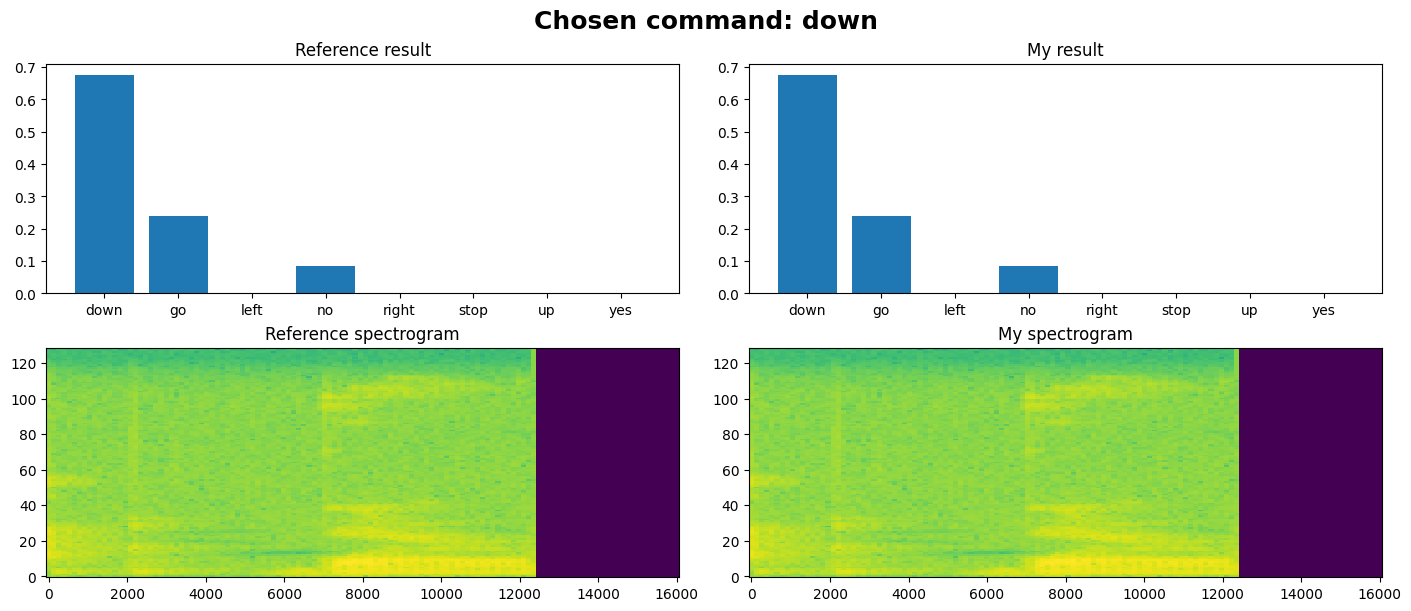

In [12]:
import time
from datetime import timedelta
layer_names = [l.name for l in model.layers]
layer_len = len(layer_names)
lastdense = True
model.summary()

for layerplace in range(layer_len):
    # First layer so we feed the data, which is stored in an appropriately named variable "x"
    start = time.time()
    if layer_names[layerplace].startswith("resizing"):
        a0 = myresize(x, 32, 32)
        end = time.time()
    elif layer_names[layerplace].startswith("normalization"):
        weights = get_layer_weights(layer_names[layerplace], model)
        a0 = mynormalize(a0, weights)
        end = time.time()
    elif(layer_names[layerplace].startswith("conv2d")): # or layer_names[layerplace] == "conv2d_1" or layer_names[layerplace] == "conv2d_2"
        #result = convolute(result, weights[layerplace])
        weights = get_layer_weights(layer_names[layerplace], model)
        a0 = convolute(a0, weights)
        end = time.time()
    elif layer_names[layerplace].startswith("max"):
        a0 = maxpool(a0)
        end = time.time()
    elif layer_names[layerplace].startswith("drop"):
        end = time.time()
        pass
    elif layer_names[layerplace].startswith("flatten"):
        a0 = flatten(a0)
        end = time.time()
    elif layer_names[layerplace].startswith("dense"):
        weights = get_layer_weights(layer_names[layerplace], model)
        w1 = weights[0]
        b1 = weights[1]
        if(layerplace == len(layer_names) - 1):
            lastdense = False
        a0 = dense2(a0,w1, b1, lastdense)
        end = time.time()
    else:
        pass
    print(layer_names[layerplace],timedelta(seconds = end-start))
# This is the result of our spectrogram
# fed into our layers
oma_result = a0

# Feed the the reference spectrogram 
# to the trained model to see how our implementation compares
reference_result = model(y)

x_labels = ['down', 'go', 'left', 'no', 'right', 'stop', 'up', 'yes']

fig, axes = plt.subplots(2, 2, figsize = (14, 6), constrained_layout = True)
fig.suptitle(f'Chosen command: {command}', fontweight = 'bold', fontsize = 18)
(ref_cmd, oma_cmd), (ref_spect, oma_spect) = axes

oma_cmd.set_title('My result')
oma_cmd.bar(x_labels, tf.nn.softmax(oma_result[0,:]))

ref_cmd.set_title('Reference result')
ref_cmd.bar(x_labels, tf.nn.softmax(reference_result[0,:]))

oma_spect.set_title('My spectrogram')
plot_spectrogram(x, oma_spect)
ref_spect.set_title('Reference spectrogram')
plot_spectrogram(y, ref_spect)